## Introduction

## Data cleaning

### Similar columns

According to description of fields from the provided documentation :  

> "fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computed from the categories field)"

Therefore, when several columns contain the same data ("countries", "countries_tags" and "countries_fr" for example), the column wth suffix "_tags" will be preferred because it is normalized.

However, some similar columns do not have the same amount of non-null values.

In [ ]:
# Compute parallel pairwise distance matrix
# @timeit
def compute_parallel_distance_matrix(X:pd.DataFrame, metric:Callable, Y=None, **kwargs):

  n_cpus = os.cpu_count()

  # Split data into chunks
  n_chunks = min(n_cpus, len(X))
  chunks = np.array_split(X, n_chunks)

  # # Parallel computation
  # distances_chunked = Parallel(n_jobs=n_cpus)(
  #   delayed(pairwise_distances)(chunk, Y, metric=metric, force_all_finite="allow-nan", **kwargs) for chunk in chunks
  # )
  N=X.shape[0]
  v=np.array(X)
  distances_chunked = Parallel(n_jobs=-1)(
    delayed(pairwise_distances)([v[i,:]], v[i+1:N,:], metric=metric, ensure_all_finite='allow-nan') for i in range(N-1)
  )

  return squareform(np.concatenate([d.flatten() for d in distances_chunked]))

In [1]:
import pandas as pd

In [19]:
members = ["test2", "test1", "test3"]

In [22]:
value_counts = pd.Series([2, 2, 2, 2], index=["test3", "test1", "test2", "test4"])

In [23]:
members_value_counts = dict((k,value_counts.get(k, 0)) for k in members)

In [24]:
members_value_counts

{'test2': np.int64(2), 'test1': np.int64(2), 'test3': np.int64(2)}

In [ ]:
max(sorted(members_value_counts), key=members_value_counts.get)

'test2'

In [ ]:
def compare_similar_columns_missing_values(df:pd.DataFrame, base_col_name:str, include_columns:list[str]=["product_name"], exclude_columns:list[str]=[]):
    # Get other simimar columns
    columns = [c for c in products if c.startswith(base_col_name) and c not in exclude_columns]

    # Look for products with at least 1 missing value among the columns AND 1 non missing value among the columns
    n_values = df[columns].count(axis=1) # Count non missing values among the columns
    condition = np.logical_and(1 <= n_values, n_values < len(columns)) # Build the condition

    return df.loc[condition, include_columns + columns] # Return products matching the condition

In [ ]:
compare_similar_columns_missing_values(df=products, base_col_name="brands")

,product_name,brands,brands_tags
181735,Grana padano,?,NaN
184680,Wortel selder salade,/,NaN
186293,Camembert rustique,/,NaN
191650,Le Centurion Emmental En Tranchettes,??,NaN
214423,Lait fermenté,--,NaN
234196,Mami nova gourmand,.,NaN
248209,[n. a!] Nature Addicts Rice Crackers Paprika,NaN,na
248211,My mix Blue Boost,NaN,na
251872,Muffins bio au seigle,?,NaN
264490,Deutsche Markenbutter,-,NaN


### Contexte

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts et fait appel aux services de votre entreprise. Cette base de données open source est mise à la disposition de particuliers et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits. 
 
Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. Dans un premier temps, vous devez vous concentrer sur la prise en main des données, et d’abord les nettoyer et les explorer. 

### Problématique

__Est-il possible de suggérer des valeurs pour certains champs lors de l'ajout d'un nouveau produit afin de réduire les erreurs de saisie et les valeurs manquantes dans la base de données Open Food Facts ?__

### Objectifs

- Identifier les variables cibles pour lesquelles il serait pertinent de suggérer des valeurs (plus de 50% de valeurs manquantes).
- Identifier les variables nécessaires pour lesquelles il est important d'avoir des données.
- Filtrer 
- Mettre en évidence les valeurs manquantes
- Identifier 3 méthodes adaptées (métiers) pour traiter ces valeurs manquantes.
- Automatiser les traitements pour éviter de répéter les opérations.


- Se servir de ces variables nécessaires pour tenter de faire des suggestions sur les variables avec des valeurs manquantes.

- Etablir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

### About RGPD

- Expliquer que la RGPD ne s'applique que dans le cadre de la manipulation de données personnelles.
- Détailler les grands principes des RGPD et en quoi ce projet reste tout de même cohérent avec ces principes.
- Expliquer ce qu'et une donnée personnelle et conclure que dans ce projet n'a pas de lien avec les RGPD.

## Imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Callable
import missingno as msno

In [2]:
# Data collection
products = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", low_memory=True)

# Using low_memory = False to remove the DTypeWarning resulted in "code" column being modified.
# For example :
# low_memory = True : 11778, 11778
# low_memory = False : 0011778, 00011778
# Duplicates seem to all be removed like this with low_memory = False

C:\Users\HCYF5290\AppData\Local\Temp\1\ipykernel_12720\3569971905.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  products = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", low_memory=True)


In [ ]:
# Data collection

# Using low_memory = False to remove the DTypeWarning resulted in "code" column being modified.
# For example :
# low_memory = True : 11778, 11778
# low_memory = False : 0011778, 00011778
# All duplicates seem to be removed like this with low_memory = False

# Keeping low_memory = True could be troublesome since it causes some columns to have mixed types

# In order to avoid any issue, dtypes of object columns is forced on read_csv.

# Collect data and store it in a DataFrame
products = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", low_memory=True)

# Define columns to convert to string to prevent mixed types
columns_to_convert = [
    'code', 'url', 'creator', 'created_t', 'created_datetime',
    'last_modified_t', 'last_modified_datetime', 'product_name',
    'generic_name', 'quantity', 'packaging', 'packaging_tags',
    'brands', 'brands_tags', 'categories', 'categories_tags',
    'categories_fr', 'origins', 'origins_tags', 'manufacturing_places',
    'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr',
    'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities',
    'cities_tags', 'purchase_places', 'stores', 'countries',
    'countries_tags', 'countries_fr', 'ingredients_text', 'allergens',
    'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size',
    'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_tags',
    'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr',
    'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
    'main_category', 'main_category_fr', 'image_url', 'image_small_url'
]

# Convert specified columns to string, preserving NaN
for column in columns_to_convert:
    products[column] = products[column].astype('object')

In [3]:
# Set the seaborn theme for plots
sns.set_theme(palette="dark")

In [ ]:
for col in products.columns:
    if products[col].dtype == "object":
        print(f"'{col}': 'object',")

In [ ]:
# Automatically get info about each variable of a given dataframe. Returns a dataframe.
def get_df_variables_info(df: pd.DataFrame) -> pd.DataFrame:
    
    # Get the shape of the DataFrame
    (n_rows, n_columns) = df.shape
    df_info = []

    # Sensitivity for top common values (15%). Used to highlight if most common values actually represent a significant proportion of the values.
    top_common_values_sensitivity = 0.15
    
    # Iterate over each column in the DataFrame
    for i, col in enumerate(df.columns):
        df_info.append({})
        # Count occurrences of each value in the column
        value_counts = df.value_counts(col)
        # Get the column type
        col_type = df[col].dtype
        # Count null values in the column
        n_null_values = df.isnull().sum()[col]
        # Count unique values
        n_unique_values = len(value_counts)
        # Count non-null values
        n_values = n_rows - n_null_values
        # Get the mode of the column
        mode = df[col].mode().values
        
        # Print basic information about the column
        df_info[i]["column_name"] = col
        df_info[i]["column_type"] = col_type
        df_info[i]["missing_value_percentage"] = round(n_null_values/n_rows*100, 2)

        # Proceed if there are non-null values
        if n_values != 0:
            df_info[i]["nbr_unique_values"] = n_unique_values
            df_info[i]["nbr_non_null_values"] = n_values 
            df_info[i]["duplicates_percentage"] = round(100-n_unique_values/n_values*100, 2)

            # If the column has fewer than 6 unique values, print their counts
            if n_unique_values < 6:
                df_info[i]["unique_values"] = ", ".join(f"{value_counts.index[i]} ({v} occurrences)" for i, v in enumerate(value_counts))

            # If the column type is numeric, gather statistical info
            if np.issubdtype(col_type, np.number):
                # Calculate quantiles, ignoring NaN values
                quantiles = np.quantile(df[col].dropna(), np.array([0.0, 0.25, 0.5, 0.75, 1.0]))
                mean = round(df[col].mean(), 2)
                
                # Print statistical summary
                df_info[i]["mean"] = mean
                df_info[i]["min"] = df[col].min()
                df_info[i]["max"] = df[col].max()
                df_info[i]["median"] = df[col].median()
                df_info[i]["std"] = round(df[col].std(ddof=1), 2)

                # # Create a boxplot for the column
                # fig, ax = plt.subplots(figsize=(9, 3))
                # ax.boxplot(df[col].dropna(), vert=False, showmeans=True, 
                #            meanprops={"markerfacecolor":'white', "marker":'o', "markeredgecolor":'firebrick', "markersize":8})

                # # Customize the plot
                # ax.grid(visible=False)

                # # Draw quantiles as vertical lines
                # ax.vlines(quantiles, [0]*quantiles.size, [1]*quantiles.size, color='chocolate', ls=':', lw=1, zorder=0)
                # ax.set_ylim(0.5, 1.5)
                # ax.set_yticklabels([])  # Hide y-tick labels
                # ax.set_xticks(quantiles)  # Set x-ticks to quantiles

                # # Annotate mean value next to the mean marker
                # ax.text(mean, 1.1, f'Mean: {round(mean, 2)}', color='firebrick', ha='center', fontsize=10)

                # # Set the plot title
                # plt.title(f"Distribution of column '{col}'")
                # plt.show()

            # Print the mode of the column
            df_info[i]["mode"] = f"""{", ".join(str(v) if i < 3 else f"... ({len(mode)} elements)" for i, v in enumerate(mode[:min(len(mode), 4)]))} ({value_counts.values[0]} occurrence(s))"""

            # Calculate top common values based on sensitivity
            n_top_common_values = int(len(value_counts) * top_common_values_sensitivity)
            top_common_values = value_counts.values[:n_top_common_values]
            
            # Check if the top common values represent a significant proportion of the data
            if value_counts.quantile(1 - top_common_values_sensitivity) / value_counts.max() < 0.25 and n_top_common_values <= 10:
                sum_top_common_values = top_common_values.sum()
                top_common_values_prop = round(sum_top_common_values / n_values, 2)
                top_common_values_info = [f"{value_counts.index[i]} ({value})" for i, value in enumerate(top_common_values)]
                
                # Print additional comments on common values
                df_info[i]["additional_comment"] = f"""First {n_top_common_values} unique values represent {top_common_values_prop * 100}% of total values : {', '.join(top_common_values_info)}"""
        else:
            # Inform if the column only contains null values
            df_info[i]["additional_comment"] = "This column only contains null values."

    return pd.DataFrame(df_info)

In [ ]:
# Visualize correlation of missing values between column pairs
# 1 means : if one variable is PRESENT then the other variable is very likely to be PRESENT.
# -1 means : if one variable is PRESENT then the other variable is very likely to be MISSING.
# 0 means : No dependance between occurence of missing values of the 2 columns.
msno.heatmap(filtered_data, figsize=(60,30))

In [ ]:
def _dfs(mat, pos, r_sum, c_sum, p_0, p):

    (xx, yy) = pos
    (r, c) = (len(r_sum), len(c_sum))

    mat_new = []

    for i in range(len(mat)):
        temp = []
        for j in range(len(mat[0])):
            temp.append(mat[i][j])
        mat_new.append(temp)

    if xx == -1 and yy == -1:
        for i in range(r-1):
            temp = r_sum[i]
            for j in range(c-1):
                temp -= mat_new[i][j]
            mat_new[i][c-1] = temp
        for j in range(c-1):
            temp = c_sum[j]
            for i in range(r-1):
                temp -= mat_new[i][j]
            mat_new[r-1][j] = temp
        temp = r_sum[r-1]
        for j in range(c-1):
            temp -= mat_new[r-1][j]
        if temp <0:
            return
        mat_new[r-1][c-1] = temp

        p_1 = 1
        for x in r_sum:
            p_1 *= math.factorial(x)
        for y in c_sum:
            p_1 *= math.factorial(y)

        n = 0
        for x in r_sum:
            n += x
        p_1 /= math.factorial(n)

        for i in range(len(mat_new)):
            for j in range(len(mat_new[0])):
                p_1 /= math.factorial(mat_new[i][j])
        if p_1 <= p_0 + 0.00000001:
            #print(mat_new)
            #print(p_1)
            p[0] += p_1
    else:
        max_1 = r_sum[xx]
        max_2 = c_sum[yy]
        for j in range(c):
            max_1 -= mat_new[xx][j]
        for i in range(r):
            max_2 -= mat_new[i][yy]
        for k in range(min(max_1,max_2)+1):
            mat_new[xx][yy] = k
            if xx == r-2 and yy == c-2:
                pos_new = (-1, -1)
            elif xx == r-2:
                pos_new = (0, yy+1)
            else:
                pos_new = (xx+1, yy)
            _dfs(mat_new, pos_new, r_sum, c_sum, p_0, p)


def fisher_exact(table):

    row_sum = []
    col_sum = []

    for i in range(len(table)):
        temp = 0
        for j in range(len(table[0])):
            temp += table[i][j]
        row_sum.append(temp)
    
    for j in range(len(table[0])):
        temp = 0
        for i in range(len(table)):
            temp += table[i][j]
        col_sum.append(temp)

    mat = [[0] * len(col_sum)] * len(row_sum)
    pos = (0, 0)

    p_0 = 1

    for x in row_sum:
        p_0 *= math.factorial(x)
    for y in col_sum:
        p_0 *= math.factorial(y)

    n = 0
    for x in row_sum:
        n += x
    p_0 /= math.factorial(n)

    for i in range(len(table)):
        for j in range(len(table[0])):
            p_0 /= math.factorial(table[i][j])

    p = [0]
    _dfs(mat, pos, row_sum, col_sum, p_0, p)

    return p[0]

In [ ]:
def chi_squared(data:pd.DataFrame, x:str, y:str):
    contingency_table = data[[x,y]].dropna().pivot_table(index=x,columns=y,aggfunc=len) 
    contingency_table.fillna(0, inplace=True)
    results = stats.chi2_contingency(observed=contingency_table)
    #print(contingency_table.to_numpy(dtype=int))
    return results

In [ ]:
test = products.dropna(subset="pnns_groups_1")
test = test[["cities_tags", "pnns_groups_1"]].dropna()
test["cities_tags"] = test["cities_tags"].str.split(',')
test = test.explode("cities_tags")
chi_squared(products.dropna(subset="pnns_groups_1"), "pnns_groups_2", "pnns_groups_1")

In [ ]:
chi_squared(products.dropna(subset="pnns_groups_1"), "pnns_groups_2", "pnns_groups_1")

In [ ]:
f_value = f_classif(features_data, target_series)

for feature in zip(features_data.columns, f_value[0]) :
        print(feature)

In [ ]:
    # always_relevant_columns = ["code", "product_name", "brands_tags", "energy_100g", "carbohydrates_100g", "fat_100g", "fiber_100g", "proteins_100g", "saturated-fat_100g", "sugars_100g", 'pnns_groups_1','pnns_groups_2']

## Data cleaning

### Similar columns

According to description of fields from the provided documentation :  

> "fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computed from the categories field)"

Therefore, when several columns contain the same data ("countries", "countries_tags" and "countries_fr" for example), the column wth suffix "_tags" will be preferred because it is normalized.

However, some similar columns do not have the same amount of non-null values.

In [ ]:
def compare_similar_columns_missing_values(df:pd.DataFrame, base_col_name:str, include_columns:list[str]=["product_name"], exclude_columns:list[str]=[]):
    # Get other simimar columns
    columns = [c for c in products if c.startswith(base_col_name) and c not in exclude_columns]

    # Look for products with at least 1 missing value among the columns AND 1 non missing value among the columns
    n_values = df[columns].count(axis=1) # Count non missing values among the columns
    condition = np.logical_and(1 <= n_values, n_values < len(columns)) # Build the condition

    return df.loc[condition, include_columns + columns] # Return products matching the condition

In [ ]:
def calc_association_pair_features(col1:str, col2:str, df:pd.DataFrame):
    dropped_df = df.dropna(subset=[col1, col2])
    if (len(dropped_df[col1].unique()) > 1000) or (len(dropped_df[col2].unique()) > 1000):
      return np.nan
    
    crosstab_result = pd.crosstab(index=dropped_df[col1], columns=dropped_df[col2])

    return association(crosstab_result)

In [ ]:
def filter_to_keep_relevant_features(df: pd.DataFrame, target:str, visualize:bool=False) -> pd.DataFrame:
    assert target != "code"

    # Remove products where there is no value for target variable
    filtered_products = df.dropna(subset=target)
    print(f"Only keeping products with non-null target ({target}) : {df.shape[0] - filtered_products.shape[0]} products removed.")

    # Remove the target from the dataset
    target_data = filtered_products[target]
    features_data = filtered_products.drop(columns=target)
    print(f"Separating target data from the rest of the data : column '{target}' removed.")

    # Define columns that will be irrelevant no matter what target is choosen.
    always_irrelevant_columns = [
       "last_modified_datetime", 
       "creator", # No useful information for prediction
       "url", # No useful information for prediction
       "last_modified_t", # No useful information for prediction
       "created_datetime",  # No useful information for prediction
       "created_t", # No useful information for prediction
       "image_url", # No useful information for prediction
       "states_tags", # No useful information for prediction
       "quantity", # No useful information for prediction and poorly filled
       "purchase_places" # No useful information for prediction and poorly filled
       ]
    features_data.drop(columns=always_irrelevant_columns, inplace=True)
    print(f"Removing columns that won't be useful to predict any target : columns '{"', '".join(always_irrelevant_columns)}' removed.")

    # Only keep columns with sufficient data (over 50%)
    insufficient_data_columns = features_data.columns[features_data.notna().mean() < 0.5]
    features_data.drop(columns=insufficient_data_columns, inplace=True)
    print(f"Removing columns with insufficient data (less than 50%) : columns '{"', '".join(insufficient_data_columns)}' removed.")

    # Drop duplicates
    columns_used_drop_dups = ["product_name", "brands_tags", "countries_tags"]
    features_data["missing_count"] = features_data.isna().sum(axis=1) # Calculate number of missing values for each product
    features_data.sort_values(by="missing_count", ascending=True) # Put products with the least missing values at the top
    features_data.drop_duplicates(subset="code", keep='first', inplace=True) # Remove duplicates but keep the first one (the one with the least missing values)
    features_data.drop_duplicates(subset=[c for c in columns_used_drop_dups if c in features_data], keep='first', inplace=True) # Remove duplicates but keep the first one (the one with the least missing values)
    features_data_without_dups = features_data.drop(columns=["code", "missing_count"])
    print(f"Removing duplicated products : {features_data.shape[0] - features_data_without_dups.shape[0]} products removed.")

    # Removing closely related features
    object_columns = features_data_without_dups.select_dtypes(include=object).columns
    association_distance_matrix = compute_parallel_distance_matrix(X=object_columns, Y=object_columns, metric=partial(calc_association_pair_features, df=features_data))
    display(pd.DataFrame(data=association_distance_matrix, columns=object_columns, index=object_columns))

    if visualize:
      msno.bar(features_data, sort="ascending")

    return target_data, features_data_without_dups

In [ ]:
ANOVA(filtered_data, x="sugars_100g", y="main_category", plot_function=sns.stripplot, order=filtered_data["sugars_100g"].groupby(filtered_data["main_category"]).mean().sort_values().index, size=4, legend=None)

In [ ]:
compare_similar_columns_missing_values(df=products, base_col_name="brands")

,product_name,brands,brands_tags
181735,Grana padano,?,NaN
184680,Wortel selder salade,/,NaN
186293,Camembert rustique,/,NaN
191650,Le Centurion Emmental En Tranchettes,??,NaN
214423,Lait fermenté,--,NaN
234196,Mami nova gourmand,.,NaN
248209,[n. a!] Nature Addicts Rice Crackers Paprika,NaN,na
248211,My mix Blue Boost,NaN,na
251872,Muffins bio au seigle,?,NaN
264490,Deutsche Markenbutter,-,NaN


In [ ]:
def imputation(df:pd.DataFrame, features_to_estimate:list[str], group_columns:list[str], method:Callable=np.mean):
    '''
    Imputes missing values for specified features in a DataFrame using group averages or a specified method.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    features_to_estimate (str): Features for which missing data needs to be imputed.
    group_columns (str): Possible grouping variables for aggregation. All combinations will be attempted and the one with the lowest variation will be chosen for each missing value.
    method (Callable): Imputation method (e.g., mean, median). Defaults to np.mean.

    Returns:
    pd.DataFrame: DataFrame with imputed values for the specified indicator.
    '''
    if not set(group_columns).issubset(df.columns):
        raise ValueError("Argument 'group_columns' should only contain valid 'df' columns")
    
    df_copy = df.copy()

    df_copy.loc[:, "group_id_set"] = df_copy.loc[:, group_columns].fillna('nan').apply(set, axis=1)

    missing_data = df_copy.loc[df_copy[features_to_estimate].isna().any(axis=1)]

    filtered_df = df_copy.loc[df_copy["group_id_set"].isin()]
    

    missing_data.loc[:, "group_id_set"] = missing_data.loc[:, group_columns].fillna('nan').apply(set, axis=1)

    df_cvs_medians = pd.DataFrame()

    # Partial function for method_if_criteria_met
    method_func = partial(method_if_criteria_met, method=method)

    for i in range(1, len(group_columns) + 1):
        for combo in combinations(group_columns, i):
            print(f'''Processing combination: "{'", "'.join(list(combo))}"''')
            df_copy["group_id"] = df_copy[list(combo)].fillna('nan').agg("_|_".join, axis=1)

            # Group by current combination and apply the function
            group = df_copy[["group_id"] + features_to_estimate].groupby("group_id").agg([coef_var, method_func])

            if df_cvs_medians.empty:
                df_cvs_medians = group
            else:
                df_cvs_medians = pd.concat([df_cvs_medians, group])

    df_cvs_medians = df_cvs_medians.dropna(how="all")

    for i in missing_data.index:
        group_id_set = missing_data.loc[i, "group_id_set"]
        matching_rows = df_cvs_medians.loc[df_cvs_medians.index.map(lambda x: set(x.split("_|_")).issubset(group_id_set))]

        missing_features = missing_data[features_to_estimate].loc[i].isna().index
        
        for feature in missing_features:
            sub_df = matching_rows[feature]
            values = sub_df.loc[sub_df["coef_var"] == sub_df["coef_var"].min(), "method_if_criteria_met"].values
            if len(values) > 0:
                df_copy.loc[i, feature] = values[0]

    return df_copy

In [ ]:
    features_data = features_data.groupby(["product_name", "brands_tags", "countries_tags", "pnns_groups_2", "main_category"]).agg(
        {'generic_name':lambda s: np.nan if len(s.dropna()) == 0 else max(s.dropna(), key=len),
        'packaging_tags':lambda s: ','.join(set([item for sublist in s.dropna().str.split(',') for item in sublist])),
        'categories_tags':lambda s: ','.join(set([item for sublist in s.dropna().str.split(',') for item in sublist])),
        'labels_tags':lambda s: ','.join(set([item for sublist in s.dropna().str.split(',') for item in sublist])),
        'stores':lambda s: ','.join(set([item for sublist in s.dropna().str.split(',') for item in sublist])),
        'ingredients_text': lambda s: s.dropna().str.cat(sep=', '),
        'additives_n': lambda s: s.dropna().max(),
        'ingredients_from_palm_oil_n': lambda s: s.dropna().max(),
        'ingredients_that_may_be_from_palm_oil_n': lambda s: s.dropna().max(),
        'nutrition_grade_fr': lambda s: s.dropna().max(),
        'energy_100g': 'mean',
        'fat_100g':'mean',
        'saturated-fat_100g': 'mean',
        'carbohydrates_100g': 'mean',
        'sugars_100g': 'mean',
        'proteins_100g': 'mean',
        'salt_100g': 'mean',
        'sodium_100g': 'mean',
        'nutrition-score-fr_100g': 'mean',
        'nutrition-score-uk_100g': 'mean',
        })

In [ ]:
def formatString(s:str):
    s = s.replace('-', ' ')
    s = s.strip()
    match = re.match(r'\w{2}:(.*)', s)
    if match:
        s = match.group(1)
    match = re.match(r'\w{2}:(.*)', s)
    if match:
        s = match.group(1)
    return s.lower()

def translateString(s:str):
    translator = Translator(user_agent = "DS_3_bis")
    s = translator.translate(s).text
    print(s)
    return s

In [ ]:
filtered_data["missing_mean"] = filtered_data.isna().mean(axis=1)
test=filtered_data.sort_values("missing_mean", ascending=False)
msno.matrix(test.drop(columns="missing_mean").loc[test["missing_mean"] < 0.5])

In [ ]:
test = pd.concat([products.loc[filtered_data.index, ["creator"]], filtered_data], axis=1).sort_values(by="creator")
fig, ax = plt.subplots(figsize=(20,10))
msno.matrix(df=test, ax=ax)
size = test.groupby("creator").size()
ymax = size.cumsum()
ymin = ymax.shift(1)
ymin.iloc[0] = 0.0
ax.vlines([-0.6]*len(size), ymin, ymax, colors=["0","1"]*int(len(size)/2))

In [ ]:
test = products.loc[filtered_data.index, ["created_datetime", "last_modified_datetime"]]

In [ ]:
filtered_data_copy = filtered_data.copy()

In [ ]:
msno.matrix(df=pd.concat([test, filtered_data_copy], axis=1).sort_values(by="created_datetime"))

In [ ]:
def calc_cv(arr:np.ndarray):
  mean = np.mean(arr)
  if mean > 0:
    return np.std(arr)/abs(mean)
  return 0

In [ ]:
individual_labels = pd.DataFrame()
individual_labels["original"] = filtered_data.loc[filtered_data["labels_tags"].notna(), "labels_tags"].str.split(',').explode().drop_duplicates()
individual_labels["formatted"] = individual_labels["original"].apply(formatString)

In [ ]:
non_english_labels = individual_labels.loc[~individual_labels["original"].str.startswith('en:'), "formatted"]

In [ ]:
individual_labels.iloc["formatted_labels"] = individual_labels["labels"].apply(translateString)

IndexError: list index out of range

In [ ]:
len(translated_list)

1918

In [ ]:
len(set([s.lower().replace(" -", " ") for s in translated_list]))

1800

In [ ]:
individual_labels["formatted_labels"] = individual_labels["formatted_labels"].str.lower()

### Using Multiple Imputation 

In [ ]:
def coef_var(values:pd.Series):
    values = values.dropna()
    if (len(values) > 20):
        mean = np.mean(values)
        if mean == 0:
            return 0
        cv = np.std(values)/abs(mean)
        if (cv < 0.3):
            return cv
    return np.nan

def method_if_criteria_met(values:pd.Series, method:Callable):
    values = values.dropna()
    if (len(values) > 20):
        mean = np.mean(values)
        if mean == 0:
            return 0
        if (np.std(values)/abs(mean) < 0.3):
            return method(values)
    return np.nan

In [ ]:
def imputation(df:pd.DataFrame, features_to_estimate:list[str], group_columns:list[str], method:Callable=np.mean):
    '''
    Imputes missing values for specified features in a DataFrame using group averages or a specified method.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    features_to_estimate (str): Features for which missing data needs to be imputed.
    group_columns (str): Possible grouping variables for aggregation. All combinations will be attempted and the one with the lowest variation will be chosen for each missing value.
    method (Callable): Imputation method (e.g., mean, median). Defaults to np.mean.

    Returns:
    pd.DataFrame: DataFrame with imputed values for the specified indicator.
    '''
    if not set(group_columns).issubset(df.columns):
        raise ValueError("Argument 'group_columns' should only contain valid 'df' columns")
    
    df_copy = df.copy()

    missing_data = df_copy.loc[df_copy[features_to_estimate].isna().any(axis=1)]

    filtered_df = df_copy.loc[df_copy[group_columns].isin()]
    

    missing_data.loc[:, "group_id_set"] = missing_data.loc[:, group_columns].fillna('nan').apply(set, axis=1)

    df_cvs_medians = pd.DataFrame()

    # Partial function for method_if_criteria_met
    method_func = partial(method_if_criteria_met, method=method)

    for i in range(1, len(group_columns) + 1):
        for combo in combinations(group_columns, i):
            print(f'''Processing combination: "{'", "'.join(list(combo))}"''')
            df_copy["group_id"] = df_copy[list(combo)].fillna('nan').agg("_|_".join, axis=1)

            # Group by current combination and apply the function
            group = df_copy[["group_id"] + features_to_estimate].groupby("group_id").agg([coef_var, method_func])

            if df_cvs_medians.empty:
                df_cvs_medians = group
            else:
                df_cvs_medians = pd.concat([df_cvs_medians, group])

    df_cvs_medians = df_cvs_medians.dropna(how="all")

    for i in missing_data.index:
        group_id_set = missing_data.loc[i, "group_id_set"]
        matching_rows = df_cvs_medians.loc[df_cvs_medians.index.map(lambda x: set(x.split("_|_")).issubset(group_id_set))]

        missing_features = missing_data[features_to_estimate].loc[i].isna().index
        
        for feature in missing_features:
            sub_df = matching_rows[feature]
            values = sub_df.loc[sub_df["coef_var"] == sub_df["coef_var"].min(), "method_if_criteria_met"].values
            if len(values) > 0:
                df_copy.loc[i, feature] = values[0]

    return df_copy

In [ ]:
group_columns=["categories_tags", "countries_tags", "pnns_groups_2"]
features_to_estimate = ["sugars_100g", "fat_100g"]
# test = filtered_data.loc[filtered_data["countries_tags"] == "France", features_to_estimate].copy()
# cProfile.run('imputation(df=filtered_data, group_columns=group_columns, features_to_estimate=features_to_estimate)', sort="cumtime")

In [ ]:
df_copy = filtered_data.copy()

missing_data = df_copy.loc[df_copy[features_to_estimate].isna().any(axis=1)]

missing_data.loc[:, "group_id_set"] = missing_data.loc[:, group_columns].fillna('nan').apply(set, axis=1)

missing_data.value_counts(group_columns)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13152\1660540425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data.loc[:, "group_id_set"] = missing_data.loc[:, group_columns].fillna('nan').apply(set, axis=1)


categories_tags                                                                                                                                                                                                                                               countries_tags      pnns_groups_2        
en:sugary-snacks,en:confectioneries,en:candies                                                                                                                                                                                                                France              Sweets                   167
en:plant-based-foods-and-beverages,en:plant-based-foods,en:fats,en:olive-tree-products,en:vegetable-fats,en:vegetable-oils,en:olive-oils,en:extra-virgin-olive-oils                                                                                           France              Fats                     143
en:plant-based-foods-and-beverages,en:beverages,en:plant-based-beverages,en:fruit-based-beverages,

In [ ]:

imputed_data = imputation(df=filtered_data, group_columns=group_columns, features_to_estimate=features_to_estimate)

Processing combination: "categories_tags"
Processing combination: "countries_tags"
Processing combination: "pnns_groups_2"
Processing combination: "categories_tags", "countries_tags"
Processing combination: "categories_tags", "pnns_groups_2"
Processing combination: "countries_tags", "pnns_groups_2"
Processing combination: "categories_tags", "countries_tags", "pnns_groups_2"


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_21204\334995877.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data["group_id_set"] = missing_data[group_columns].fillna('nan').apply(set, axis=1)


,code,product_name,generic_name,quantity,packaging_tags,brands_tags,categories_tags,labels_tags,purchase_places,stores,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,group_id
174,290616,Salade Cesar,Laitue en salade,0.980 kg,frais,kirkland-signature,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,NaN,Costco,...,12.000000,7.0,23.0,NaN,22.00,2.1600,0.850,6.0,6.0,"en:plant-based-foods-and-beverages,en:plant-ba..."
175,394710,Danoises à la cannelle roulées,Pâtisserie,1.150 kg,frais,kirkland-signature,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",NaN,Brossard Québec,Costco,...,14.400000,NaN,54.1,28.1,4.79,0.9220,0.363,NaN,NaN,"en:sugary-snacks,en:biscuits-and-cakes,en:past..."
177,1071894,Flute,Flute,NaN,"paper,plastic-film",waitrose,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,"Brent,UK",Waitrose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:plant-based-foods-and-beverages,en:plant-ba..."
180,1938067,Chaussons tressés aux pommes,Pâtisserie,1.200 kg,frais,kirkland-signature,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",NaN,Brossard Québec,Costco,...,10.700000,2.0,38.7,24.7,3.33,0.6470,0.255,9.0,9.0,"en:sugary-snacks,en:biscuits-and-cakes,en:past..."
182,5200016,lentilles vertes,NaN,1 kg,sachet-plastique,bertrand-lejeune,"en:plant-based-foods-and-beverages,en:plant-ba...","en:organic,en:eu-organic,fr:ab-agriculture-bio...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:plant-based-foods-and-beverages,en:plant-ba..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320736,9901198001583,Лимон — лайм,NaN,2,NaN,пеликан,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:plant-based-foods-and-beverages,en:plant-ba..."
320740,99111250,Thé vert Earl grey,thé bio équitable,50 g,"boite,carton",lobodis,"en:plant-based-foods-and-beverages,en:beverage...","en:fair-trade,en:organic,en:eu-organic,en:max-...",NaN,NaN,...,0.200000,0.2,0.5,0.5,0.50,0.0254,0.010,2.0,0.0,"en:plant-based-foods-and-beverages,en:beverage..."
320742,9935010000003,Rillette d'oie,NaN,180 g,"pot,verre","sans-marque,d-lambert","en:meats,en:spreads,en:prepared-meats,en:salte...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:meats,en:spreads,en:prepared-meats,en:salte..."
320743,99410148,NaN,NaN,NaN,plastique,NaN,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,NaN,NaN,...,47.123810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:plant-based-foods-and-beverages,en:plant-ba..."


In [2]:
import pandas as pd
import seaborn as sns

In [4]:
data ={'proteins_100g':["Can be estimated"]*1273 +["Insufficient data and variation too high"]*15397 +["Insufficient data"]*2482 +["Variation too high"]*235,
 'sugars_100g':["Can be estimated"]*1465+["Insufficient data and variation too high"]*17633 +["Insufficient data"]*2685  +["Variation too high"]*417 ,
 'carbohydrates_100g':["Can be estimated"]*1113 +["Insufficient data and variation too high"]*16561  +["Insufficient data"]*2226 +["Variation too high"]*660 ,
 'saturated-fat_100g':["Can be estimated"]*1663 +["Insufficient data and variation too high"]*20410  +["Insufficient data"]*3201  +["Variation too high"]*505 ,
 'fat_100g':["Can be estimated"]*1217 +["Insufficient data and variation too high"]*15397 +["Insufficient data"]*2482 +["Variation too high"]*235,
 'sodium_100g':["Can be estimated"]*1465+["Insufficient data and variation too high"]*15397 +["Insufficient data"]*2482 +["Variation too high"]*235,
}

In [3]:
import textwrap as twp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
sns.set_theme(palette="pastel")

In [9]:
test = pd.DataFrame(
    [["proteins_100g", "Can be estimated"]]*1273 +[["proteins_100g", "Insufficient data and variation too high"]]*15397   +[["proteins_100g", "Insufficient data"]]*2482   +[["proteins_100g", "Variation too high"]]*235   +
    [["sugars_100g", "Can be estimated"]]*1465  +[["sugars_100g", "Insufficient data and variation too high"]]*17633   +[["sugars_100g", "Insufficient data"]]*2685    +[["sugars_100g", "Variation too high"]]*417   +
    [["carbohydrates_100g", "Can be estimated"]]*1113   +[["carbohydrates_100g", "Insufficient data and variation too high"]]*16561    +[["carbohydrates_100g","Insufficient data"]]*2226   +[["carbohydrates_100g","Variation too high"]]*660 +
    [["saturated-fat_100g", "Can be estimated"]]*1663   +[["saturated-fat_100g", "Insufficient data and variation too high"]]*20410    +[["saturated-fat_100g", "Insufficient data"]]*3201     +[["saturated-fat_100g", "Variation too high"]]*505 +
    [["fat_100g", "Can be estimated"]]*1217   +[["fat_100g", "Insufficient data and variation too high"]]*18066 +[["fat_100g", "Insufficient data"]]*2589  +[["fat_100g", "Variation too high"]]*547  +
    [["sodium_100g", "Can be estimated"]]*2283  +[["sodium_100g", "Insufficient data and variation too high"]]*17426   +[["sodium_100g", "Insufficient data"]]*3375   +[["sodium_100g", "Variation too high"]]*12 
    )

In [16]:
test = pd.DataFrame(
    [["proteins_100g", "Can be estimated"]]*1273 +[["proteins_100g", "Insufficient data and variation too high"]]*1529    +[["proteins_100g", "Insufficient data"]]*16350    +[["proteins_100g", "Variation too high"]]*235   +
    [["sugars_100g", "Can be estimated"]]*1465  +[["sugars_100g", "Insufficient data and variation too high"]]*2008    +[["sugars_100g", "Insufficient data"]]*18310     +[["sugars_100g", "Variation too high"]]*417   +
    [["carbohydrates_100g", "Can be estimated"]]*1113   +[["carbohydrates_100g", "Insufficient data and variation too high"]]*2250     +[["carbohydrates_100g","Insufficient data"]]*16537     +[["carbohydrates_100g","Variation too high"]]*660 +
    [["saturated-fat_100g", "Can be estimated"]]*1663   +[["saturated-fat_100g", "Insufficient data and variation too high"]]*2058     +[["saturated-fat_100g", "Insufficient data"]]*21553      +[["saturated-fat_100g", "Variation too high"]]*505 +
    [["fat_100g", "Can be estimated"]]*1217   +[["fat_100g", "Insufficient data and variation too high"]]*2033  +[["fat_100g", "Insufficient data"]]*18622   +[["fat_100g", "Variation too high"]]*547  +
    [["sodium_100g", "Can be estimated"]]*2283  +[["sodium_100g", "Insufficient data and variation too high"]]*1644    +[["sodium_100g", "Insufficient data"]]*19157    +[["sodium_100g", "Variation too high"]]*12 
    )

In [ ]:
test = pd.DataFrame(
    [["proteins_100g", "Can be estimated"]]*12413+[["proteins_100g", "Insufficient data and variation too high"]]*102  +[["proteins_100g", "Insufficient data"]]*326  +[["proteins_100g", "Variation too high"]]*5459  +
    [["sugars_100g", "Can be estimated"]]*5451 +[["sugars_100g", "Insufficient data and variation too high"]]*475  +[["sugars_100g", "Insufficient data"]]*347   +[["sugars_100g", "Variation too high"]]*14638  +
    [["carbohydrates_100g", "Can be estimated"]]*1857  +[["carbohydrates_100g", "Insufficient data and variation too high"]]*471   +[["carbohydrates_100g","Insufficient data"]]*299  +[["carbohydrates_100g","Variation too high"]]*16991  +
    [["saturated-fat_100g", "Can be estimated"]]*9165  +[["saturated-fat_100g", "Insufficient data and variation too high"]]*33   +[["saturated-fat_100g", "Insufficient data"]]*57   +[["saturated-fat_100g", "Variation too high"]]*15062  +
    [["fat_100g", "Can be estimated"]]*3234  +[["fat_100g", "Insufficient data and variation too high"]]*88  +[["fat_100g", "Insufficient data"]]*1  +[["fat_100g", "Variation too high"]]*18074  +
    [["sodium_100g", "Can be estimated"]]*20592 +[["sodium_100g", "Insufficient data and variation too high"]]*43  +[["sodium_100g", "Insufficient data"]]*374  +[["sodium_100g", "Variation too high"]]*0
    )

Text(0.5, 1.0, "Results of median imputation using 'generic_name'")

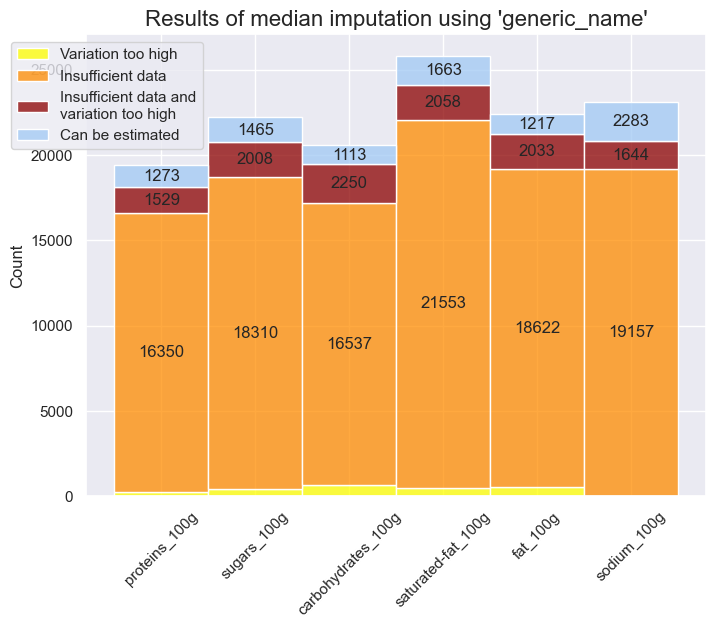

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
hue_order = ["Can be estimated", "Insufficient data and variation too high", "Insufficient data", "Variation too high"]
hue_colors = ["b", "darkred", "darkorange", "yellow"]
sns.histplot(test, x=0, hue=1, multiple="stack", hue_order=hue_order, palette=hue_colors, ax=ax)
for c in ax.containers:
  labels = [int(v.get_height()) if int(v.get_height()) > 1000 else '' for v in c]
  ax.bar_label(c, labels=labels, label_type='center')
legend_labels = [twp.fill(s, 25, break_long_words=False) for s in hue_order]
legend_labels.reverse()
ax.legend(labels=legend_labels, bbox_to_anchor=(0.2,1))
ax.get_legend().set_title(None)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel(None)
ax.set_title("Results of median imputation using 'generic_name'", size=16)

In [ ]:
def getImputationScore(ref:pd.DataFrame, test:pd.DataFrame, imputed:pd.DataFrame):
    
    ref_copy = ref.copy()
    imputed_copy = imputed.copy()

    df_compare = ref_copy.compare(imputed_copy, keep_shape=True, keep_equal=True)
    mask_na_after_multiindex = ref_copy.compare(imputed_copy, keep_shape=True, keep_equal=True).isnull()
    mask_na_after_multiindex = mask_na_after_multiindex * 3

    mask_diff_multiindex = ref_copy.compare(imputed_copy, keep_shape=True).notnull()
    mask_diff_multiindex = mask_diff_multiindex * 2

    mask_na_initial = test.isna()
    mask_na_initial_multiindex = pd.DataFrame(columns=df_compare.columns)
    for col in mask_na_initial.columns:
        mask_na_initial_multiindex[col, 'self'] = mask_na_initial[col]
        mask_na_initial_multiindex[col, 'other'] = mask_na_initial[col]

    mask_color_multiindex = mask_na_initial_multiindex + mask_diff_multiindex + mask_na_after_multiindex
    
    def apply_color(x):
        colors = {0: 'black', 1: 'green', 2:'fuchsia', 3:'maroon', 4:'red'}
        return mask_color_multiindex.map(lambda val: 'background-color: {}'.format(colors.get(val,'')))
    
    numeric_columns = ref_copy.select_dtypes(include=np.number).columns
    # Scale between 0 and 1
    scaler = MinMaxScaler()
    ref_copy[numeric_columns] = pd.DataFrame(scaler.fit_transform(ref_copy[numeric_columns]), columns=numeric_columns)
    imputed_copy[numeric_columns] = pd.DataFrame(scaler.transform(imputed_copy[numeric_columns]), columns=numeric_columns)
    
    # Transform columns with list-like values with split
    for col in LISTLIKE_COLS:
      if col in ref_copy:
        ref_copy[col] = ref_copy[col].apply(lambda x: x.split(',') if isinstance(x, str) else x)
        imputed_copy[col] = imputed_copy[col].apply(lambda x: x.split(',') if isinstance(x, str) else x)

    def calc_score(ref:pd.Series, mask:pd.Series, imputed:pd.Series):
      """Compute the custom metric efficiently."""
      # Convert to NumPy arrays
      ref = np.array(ref, dtype=object)
      imputed = np.array(imputed, dtype=object)
      mask = np.array(mask, dtype=bool)
      str_score = [x == y if isinstance(x, str) and isinstance(y, str) else 0 for x, y in zip(ref, imputed)]
      numeric_score = [score_nan_and_numeric(x, y) if isinstance(x, (int, float, type(pd.NA), type(None))) or isinstance(y, (int, float, type(pd.NA), type(None))) else 0 for x, y in zip(ref, imputed)]
      non_numeric_score = [set(y) and len(set(y).intersection(x)) / len(set(y)) if isinstance(x, list) and isinstance(y, list) else 0 for x, y in zip(ref, imputed)]
         
      # Combine numeric and non-numeric differences
      difference = [string + num + non_num for string, num, non_num in zip(str_score, numeric_score, non_numeric_score)]
      
      # Compute mean and sum
      mean_dist = np.mean(difference, where=mask)
      sum_dist = np.sum(difference, where=mask)
      
      return mean_dist, sum_dist
    
    col_scores = {}

    for col in ref_copy:
        mean_dist, sum_dist = calc_score(ref_copy[col], mask_na_initial[col], imputed_copy[col])
        col_scores[col] = [mean_dist, sum_dist]

    score_df = pd.DataFrame(data=col_scores, index=["mean", "sum"])

    str_cols = list(set(ref.select_dtypes(include="object").columns) - set(LISTLIKE_COLS))
    num_cols = ref.select_dtypes(include=np.number).columns

    score_df["num"] = [score_df[num_cols].loc['mean'].mean(), score_df[num_cols].loc['sum'].sum()]
    score_df["str"] = [score_df[str_cols].loc['mean'].mean(), score_df[str_cols].loc['sum'].sum()]
    score_df["listlike"] = [score_df[[col for col in LISTLIKE_COLS if col in score_df.columns]].loc['mean'].mean(), score_df[[col for col in LISTLIKE_COLS if col in score_df.columns]].loc['sum'].sum()]
    score_df["global"] = [score_df.loc['mean'].mean(), score_df.loc['sum'].sum()]
    
    return score_df, df_compare.style.apply(apply_color, axis=None)

In [ ]:
products.loc[products["ingredients_text"].notna() & products["ingredients_text"].str.contains("BREWED AND ANHEUSER-BUSCH"), "ingredients_text"]

14168    4,2 % ALC./VOL - BREWED AND ANHEUSER-BUSCH. SI...
Name: ingredients_text, dtype: object

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(filtered_data.loc[filtered_data["ingredients_text"].notna() & filtered_data["ingredients_text"].str.contains("BREWED AND ANHEUSER-BUSCH"), "ingredients_text"])

14168    4,2 % ALC./VOL - BREWED AND ANHEUSER-BUSCH. SI LOUIS MO
Name: ingredients_text, dtype: object

In [ ]:
s = "VLOEIBARELIGHTROOMJ' 15% VET, UHT&quot;- GESTERILISEERD - Light room (melk herkomst: Frar melkeiwitten"
sep_pattern = '|'.join(sorted(list(set([",", r"\(", r"\)", r"\[", r"\]", r"\.", ";", r"[^\w]-[^\w]", r"[^\w]·[^\w]", r"[^\w]—[^\w]"])-set(',')))) # sorting the list to get consistent results
re.sub(sep_pattern, ",", s, flags=re.UNICODE)

"VLOEIBARELIGHTROOMJ' 15% VET, UHT&quot,- GESTERILISEERD,Light room ,melk herkomst: Frar melkeiwitten"

In [ ]:
sorted(list(set([",", r"\(", r"\)", r"\[", r"\]", r"\.", ";", r"[^\w]-[^\w]", r"[^\w]·[^\w]", r"[^\w]—[^\w]"])-set(',')))

[';',
 '[^\\w]-[^\\w]',
 '[^\\w]·[^\\w]',
 '[^\\w]—[^\\w]',
 '\\(',
 '\\)',
 '\\.',
 '\\[',
 '\\]']

In [ ]:
# Above cell result should look like this : 
# [';',
#  '[^\\w]-[^\\w]',
#  '[^\\w]·[^\\w]',
#  '[^\\w]—[^\\w]',
#  '\\(',
#  '\\)',
#  '\\.',
#  '\\[',
#  '\\]']

In [ ]:
translated_list = """ab
point vert
Without artificial aromas
Contains GMOs
incorrect data on label
utz certified kakao
vegetarian
vegan
Made in France
vegetarian
vegan
Without artificial dyes
vegetarien
lightened in fat
vegetarian
minus 30% fat
organic
Eu Organic
FR: Ab Agriculture Organic
without coloring
conservative
cooked in France
leeeeeeet it goooooooo
vegetarian
forever fish
not the droid you're looking for
Little or no fat
little fat
fsc
minus 35% fat
fsc mix
weight watchers
gluten free
no gmos
no preservatives
protected geographical indication
usda organic
Made in Canada
sans gluten
kosher
no artificial colors
no artificial flavors
share
orthodox union kosher
low or no fat
low fat
reduced fat
25% less fat
0g trans fat
less than 1 g sugar
no high fructose corn syrup
not a sodium free food
chicago rabbinical council
crc
cocker
green dot india
halal
whole grain
suitable for vegetarians
sweet & spicy
crispy and crunchy
CRC PAREVE
utz certified
taste tested by customers
Made in the United Kingdom
pure butter
fair trade
no caffeine
no artificial sweeteners
vegan
fairtrade
not GMO
fairtrade international
artificially favoured
u
new!
no synthetic colors
cheese from cows not treated with the growth hormone
25% less sodium
non gmo project verified
100% organic
or Kosher
no cholesterol
0 g trans fat
labels for education
u first
d
baked with real cheese
Made in Luxembourg
incorrect nutrition facts on label
no sugar added
bio
European organic
it bio 006
Agriculture Italy
French meat
French poultry
real cinnamon & sugar in every delicious bite
naturally flavored
no high fructose
green dot
green dot
made with sustainable palm oil
pediatrician's #1 choice for children's chewable vitamin brand
with the latest (institute of medicine
2010) recommanded level of vitamin d to support strong bones
French cream
Intermarché selection
kosher for passover: under the supervision of rabbinate of afula
organized kashrut kosher
keep refrigerated
no salt added
can be frozen
congelable
ud
all natural ingredients
refrigerate after opening
vegetarians
no artificial dyes
no artificial preservatives
original flavor
aged for six months
Contains milk
k
from cows not treated with artificial growth hormones
grade a
pasteurized
homogenized
no msg
natural country
american masters of taste
ⓤ
thailand diversity & refinement
the islamic comittee office of thailand
first grade tis 3 1983
25% reduced fat
cholesterol free
no trans fat
all natural
low sodium
gb org 02
made in france
source de calcium
Organic Certificate by Quality Assurance International
organic
DLG awarded annually
german agricultural society
it bio 004
Association & quot; soil and health & quot;
Operator Controle N ° 25042
authorized by MIPAAF
dlg
flavors of the year 2013
Ab Agriculture Organic
soil and health association Italy
50% less sodium than table salt
50% more calcium than dairy milk
gentle on your stomach
great taste
mountain grown
gluten free food
100% natural
american heart association
low or no sugar
low sugar
reduced sugar
25% less sugar
made with real cheese
classic
fair trade
imported
real whole dried fruit
GMO without GMOs
Made in Italy
kiwa certified
100% whole grain
american heart association certified
do not microwave
refrigeration not required
rainforest alliance certified
non gmo project certified
certified gluten free
72% cocoa
10% net profits donated
certfied vegan
no msg added
made in usa
triangle kosher
Without added aromas
sweetening
incorrect nutritional information on the packaging
pure juice
gelatin free
made in the usa
no fat
real fruit
proudly made in hawaii
minus 15% fat
pure beef
100% muscle
rainforest alliance
ethical trade
lactose free
made with whole grain
sustainable palm oil
naturally and artificially flavored
rspo mixed
rspo 1106186
green palm
no vegan
personco
kehilla kosher
hive
official dip sponsor of the nfl
official sponsor of the nfl
hive
ok kosher
rabbi m. weissmandl kosher
from cows not treated with rbst
rbst free
tablet k kosher
50% less fat
no lactose
cholesteral free
gluen free
high in fiber
derived from rbst treated and non rbst treated cows
fat -free
100% naturel
100 calories per bag
whole natural
wheat free
I am not
peanut
done with real almonds
casein
soyy
sin gluten
Without egg
Lactose without lactose
No milk
Without soybeans
50% less fat than the leading brands
35 calories per wedge
light
0 grams trans fat
gluten -free
Deputy
low -fat
ner tamid k
wheatless
us org 050
vegetarian society
soy
without dairy products
Suitable for vegetarians
k the money
Cardboard from recycled paper
Plastic from recycled plastic
bio agriculture non ue
us org 050?
ingredient from organic farming.
vegetarian society approved
sans lactose
ok kosher certification
milk -free
Non -European organic
source of calcium
source of vitamin b12
artificial flavor
mild smoke
tastes of scotland
de öko 001
ultra thin
water added
97% fat free
thai quality label
the central islamic committee of thailand
soil association
gb org 05
p
sodium free
free of artificial preservative
free of artificial color
free of artificial flavors
real california milk
fast dissolve
to the parves
rich in omega 3
0 g sat fat
0 g sugars
good source of omega 3
no saturated fat
pure juice
fat free
quality assurance international certified organic
high in omega 3
omega 3
#1 choice of choosy moms
Sodium low
for export only
no hfcs
made with whole fruit
no hpcs
ethically sourced cocoa
ca org 006
agriculture canada
agriculture non ue
Union Orthodox
Quebec Food
canada 263
sugar -free
cor
Warranty Sobeys +
m
Halal certified
no artificial flavours
sans aspartame
fat -free
Without added sugar
EN: Eu Organic
en: Fr Bio 01
without gelatin
Food prepared Quebec
Biological Canada
no milk
low fat
without cholesterol
Trans -free
little salt
low -top content
little or no salt
Little or no sugar
without added salt
without added sugar
no artificial flavours or colours
source of iron
cor 481
milkman
canada a
australian made
rich in vitamin c
fcs
ancestors
unsweetened
vegecert
source of omega 3
Certified allergen control: absence of peanuts
u.s. inspected and passed by department of agriculture
naturally fat free
pasteurised
0% fat
mk kosher
Certified organic by Quebec True
made with real cheddar cheese
Ecosocial certified by IBD
peanut free
peanut
ecocert canada
Biological certified by OCQV
Without aromas or artificial colors
Source of omega 3
100% done with chicken eggs in freedom
Canadian association of celiac disease
Food prepared in Quebec
Canadian Diabetes Association
made from Quebec wheat flour
15 essential nutrients
Quebec wheat flour
preservative free
by appointement to her majesty queen élizabeth ii
repack
tidy man
RST AE36
by appointment of her majesty the queen
naturally caffeine free
by appointment to her majesty the queen elizabeth ii
tidyman wastebasket
recycle
eac
Trimans
fork
mild
dairy free
no gmo
aoc
our assurance quality
caffeine free
grade aa
37% less fat
French producers
Organic certified
Without conservation agents
unrelated
without genetic engineering
suitable for freezing
u.s. no. 1 grade
calorie free
gelatin
real seal
keep frozen
huile sun kernel
non gm ingredients
no hydrogenated oil
Made in Switzerland
Ch bio 006
fsc c104754
Fr Bio 001
without lecithin
no gluten
kosher supervision of america
sulfite free
no bisphenol a
managed fisheries
bpa free
natural source of omega 3
nitrogen flushed for freshness
square k orc
orthodox rabbinical council of san francisco
whole grains
Biological certified by Quality Insurance International
100% flourless
flavors of the year 2015
haccp
sugars
carb free
Kasher
44% less fat
k v
live & active cultures
the best value in popcorn
v
gentle on the stomach
sweet
caring dairy
kosher dairy
Max Havelaar
fairer handel
good protein source
colorless
wisconsin master's mark
islamic food and nutrition council of america
ⓜ
low or no salt
ccof certified organic
no salt
aim for health
certfied humane
free roaming
Not recommended for pregnant women
gb5 org 05
soil association organic
p.g.i.
fsc c018604
sustainable fishing
Eco packaging
made in uk
it bio 007
palm oil
fiber -rich
no sugar
rich coconut fat content 17%
non gmo project
40% less fat
orga
Without pipes
wind powered
cholesterol lowering
super value
humane farming
No rbst
american human
american cheese society 2016 winner
fssai fssl 10012021000063
iso 22000
iso 9001
coconut milk included
export product
LPPOM 00060000421298
Category I
natural aromas
100% natural sugar
made in mexico
vegan society
made in respect
85% cacao
non dairy
vegan
award winning
no antibiotics
no synthetic hormones
no toxic pesticides
pasture raised
wisconsin grade aa
oregon tilth certified organic
non homogenized
egg -free
without corn syrup
Controlled fish sector
Guaranteed quality
sans polyphosphate
visalim
without artificial growth hormone rrst
usda
no hydrogenated oils
canada 290
30% less fat
ksa
no suggar added
80% less fat
low sodium content
freedom food
rspca monitored
aop
no need to refrigerate
it bio 009
1 of 5 a day
british
source of thiamin
uat
uht
milk
Origin France
made in england
crafted in england
Exclusive Deluxe selection
rspca assured
fsc 014047
cold extract
Ecocert FR Bio 01
Fr Bio 01
so sulphur added
vegetarian & vegan
negroni
Product in Brittany
ES 12.00215/bi what
british lion quality
barn
class a
reduces cholesterol
spanish pork
german pork
Charter Lu Harmony
Denomination de origin controllatta
klbd kosher
fair traide
fflm0677
freedom food   rspca monitored
health warning
good source of fiber
kosher
no milk hormones
taste the difference
canada organic
non gm0 project
GMO project
biological
Warranty Bio
county
made in China
albeit brebis
assured food standards
red tractor
Charolaise breed
Charolais meat
French pork meat
French pork
line sin
trawling
casserole
Mailing nets sin
French beef
france
deflected on site
FR BIO 10
special offer
Creation butchers of excellence
air -cooled
label rouge
Gold flavors
high in France
shot in France
born in France
outdoor
farm chicken
Contains gluten
distributor labels
superior quality
Paris gold medal 2015
French milk
French pork
Fr Bio 09
class A
agriculture france
certipaq
Protected geographic indication
brought up
100 vegetable gardens to win
igp
nourished without GMOs
1 planted tree
84 days of minimum breeding.
outdoor
Farm poultry of praise raised in freedom
aromas
Smoked with beech wood
Chicken nourished without GMOs
Protected geographic indication
ecocert
French Halal meat control company
Defeated according to the Muslim rite
nourished with 100 % mineral and vitamins
born and raised in France
Ritual association of the Great Mosque of Lyon
100% vegetable food
no carbs per serving
raw milk
blue white heart
Tradition linen sector
fsc c014047
Agriculture Rhône Alpes
triangle k
organic partner
fiber source
agriculture rhônes alpes
Sin to the line and hook
trapped
Sin with a format fillet
naturel
sans phosphate
cracked with lockers
ccp
gourmet product
Raised in France
CCP certified
Control of the Mosque of Évry Courcouronnes
British lamb quality standard
BIO Solidarity
100% recyclable and biodegradable bag
quality product
tradition
Carrefour quality
outer
outdoor
South West certified foie gras duck
natural conservation
Original ox France
100% vegetable food
Raised in France
assure food standards
the prince's countryside fund
pgi
family business
craft product
harvests tested and controlled (pesticide and heavy metal analysis)
tesco nurture
info tri point vert
nurture
dolphin friendly
fished by pole & line
caught by pole & line
100 % pure juice
produced in france
ECOLOGY EU
ecological
At your service
USDA organic
free wizard and witches card inside
KSR
without adding Arou
does not contain GMOs
International Beer Challenge 2013 gold medal
may be frozen
perishable
fiber source
reduced sodium content
gb org 04
Eco Emballage
organic food federation
paleo
raw food
cru
Without trans fatty acids
decaffeinated
made in the ue
natural flavors
sugar lightened
100% pure ginseng no sugar added guarantee
ethical tea partnership
Made in England
not omg
no soy added
no nitrate or nitrite added
no artificial ingredients
sugar free
bsf certified
manufactured in a cgmp facility
certified cgmp
sol association
nap
superfruit
Quebec product
bctgm union made
proudly
a30 3004 12smru
Natural product
1% for the planet
ksa kosher
Qai Organic certfied (USA)
agriculture durable
no partially hydrogenated oil
palm oil free
bland 231509000
taiwan recycling
A secular tradition
fresh from the oven taste
plant a tree
lactosefrei
5 times distilled
from wheat
M&M First quality
mk
Made in a peanut -free factory
heart healthy. nothing artificial.
kosher. vegan.
no corn syrup
GI Low
true Quebec
locker
rbgh free
gmp
100 % wind power
natural
I am free
belgian family brewers
belgian hops
no preservatives added
no eggs
no honey
no refined sugars
non gmo verified
formerly grade b
iso 9001:2008
quality chekd
low fat honey
Biological certified by Quality Insurance International
rainforest alliance certified cocoa
kosher certification service
50% less salt
virginia's finest
No alcohol
premium quality
free from any coloring agent
ca local
kascher
low salt
primary source
no artificial flavors or sweeteners
ECO Packaging
100% effective
100% legal
natural pain killer
prolong sexual intimacy
no additives
no synthetic ingredients
real california cheese
flavors of the year
flavors of the year 2014
estate bottled
health
slimming meal
Quebec Food
sans gms
aliments quebec
Food prepared in Quebec
Without the use of antibiotics or X hormones
sea salt
microwavable
no refrigeration
gmo free
no sugar alcohols
no artificial food color
south african national halal authority
gf
paleo
suitable for diabetics
raw
without palm fat
it bio 008
Korc
not advised for pregnant women
sustainable fishery
ocean wise recommended
without artificial dyes
Without artificial aromas
No artificial preservatives
gluten -free
low fat content
low in calories
easy to digest
Lactose free
G.U.
kurz hive
organic soil association
without aloin
Without artificial curator
no hexane
no transfat
Made in Mexico
biodynamic
naturally rich in omega 3
sustainably caught
care enough
european organic
star k kosher
unpasteurized
gold superior taste
rear tasteless
Zero calories
no colorings
sans fructose
kof
no flavour enhancer
non gmo potatoes
non gmo sunflower oil
nut free
fully natural
quality usa
choice category
no
deposit
45% sugars
canda organic
vampire killer
sans calories
San Caffeine added
no added oil
good free
non gmo porject verified
no nitrates added
no nitrites added
egg free
sans msg
Without artificial coloring
A portion of individual
Protein photo
Havelaar
CN Bio 154
cold processed
pl eko 07
Without preservatives
GOST R 54679 2011
irish dental association approved
british dental health foundation approved
high fibres
no nuts
u.s. inspected and passed by department of agriculture est. 18615
Zabiha Halal
100% all natural
real belgian chocolate
produce of mexico
Made in Germany
agriculture ue
class ii
se eco 01
100% guadeloupe
pest harvest treatment
grown by a. hernandez
supplier code dl03
assured food standard
40% fewer calories
Belgian milk
In organic 154
agriculture inde
palm oil
heart foundation tick
utz
agriculture ue/non ue
no artificial colours or flavours
no added preservatives
already washed
In sunflower oil
eco -packaging
DK EKO 100
utz certified cocoa
100% recycled paperboard
Tu 9164 002 25849819 2015
Since 1844
traditional manufacture
Alpina sector
Savoie Tradition Origin
swedish recipe and quality
utz certified tea
de öko 013
utz certified cacao
biogarantie
General Agricultural Competition
Silver medal of the general agricultural competition
GENERAL AGRICULTURE 2012 competition silver medal
99% fat free
casher
en:organic
Origin France Guarantor
GOST 31450 2013
We guarantee quality
RST HASSP
NL BIO 01
alcoholless
fairly traded
Since 1872
Made in Normandy
Delois France
GOST 19792 2001
rs
Voluntary certification of RST
Manual package
The product is certified
DLG Golden Prize 2016
100 % quality from Azerbaijan
not recommended for increased acidity of gastric juice and pancreatitis
It is recommended to use in diluted form
TR TS 021/2011
TR TS 022/2011
TR TS 023/2011
Tu 9163 001 25789253 2015
Bright taste of natural products
Made by nature
Tu 9198 001 67467291 2010
stone -cooked
Ingredients of natural origin
is echo 023 ma
trans fat free
steam prepared
Salt limited content
Cooperative product
Protected Product from Spain
vp
VP Campo de la Guardia
Doca Rioja
The vegetation
with sulfites
vegan product
Mâcon gold medal 2003
harvesting owner
Carrefour quality commitment
lightened in sugars
0 sucres
bio dynamie
demeter
is echo 025 na
100 % whole grain
certified by oregon tilth
1% for the planet
stonewood
18 % mg
30 % mg
4 % mg
Milk of French farms
pdo
Keep up to 8 a.m. out of the fridge
South West foie gras duck
sustainable farming
to bio 402
Reblochon farmer
Made in Brittany
sans polyphosphates
Ideal for vegetarians
baked not fried
no colourings
dream i don't big
made in italy
Produced in Italy
MSC sustainable fishing
c bv 667461 fr
Developed in France
Quality without ridge
MSC certificate of sustainable fishing
Without sulfites added
agriculture ue / non ue
Gold quality recipe
ab ecocert
certification bio: be bio 02
quality label & quot; aha! & quot;Swiss allergy center
Without taste enclosure
sans glutamate
additives free
eggs and egg derivates free
nitrogen colouring additives free
No OGM
Tested by the Carrefour test panel
Boeuf 100% France
non -GMO
gluten -free
biological certificate
Fairtrade Max Havelaar
Without added sugar
little sugar
craft
Product in Ile de France
flavors Paris Ile de France
goat cheese
stone oven
Rich in omega 3
Charter Lu Harmony (70% of wheat cultivated according to this charter)
Homemade sausages
French apples
French organic milk 1% for the planet
AB certified by FR Bio 01 Agriculture France
100% organic product
ECO 019 CT
gr Bio 01
No preservatives
with olive oil
81% cacao
AQCF
EG ÖKO regulation
de öko 024
EU /not EU agriculture
sial innovation paris 2014
organic certified
orhanic certified
sial innovation
Made in Belgium
Quality without edges
sial innovation 2014
organic certfied
organic certification
100% pork
gl 72
freshness
gl 71
No Ecotax
AOP reblochon
Freshness witness
Bronze medal of the General Agricultural Competition
Bronze medal of the General Agricole 2015 competition
Biodynamic Landwirtschaft
de öko 022
German agriculture
Almond olives
g.g.a.
AOP Beaujolais Nouveau
usda a grade
free range
heirloom
sustainable seafood msc
MSC 100 52642
Category I
Extra category
trawling
Bottle -beam fishing
almond milk
vegetable milk
creamy
msc
MSC 100 53228
Contains alcohol
befer
Made in Germany
Category I
Health register: H0601010n Naehry
sweetener
igp Ardèche
aop rully 1er cru les cloux
AOC Bourgogne Hautes Cotes de Beaune
Agri Confidence
Milk Origin France
box tops for education
electrolytes
no colors from artificial sources
source of energy
vitamin b12
vitamin c
freshness
Freshness in closed envelope
High Alps naturally
durable palm oil
fsc mixte
Swiss organic budding
DLG Golden Prize 2015
DLG Golden Price
fsc c041248
point
oil -free
without soy lecithin
de öko 006
PT BIO 03
Farmer yogurt
No preservatives
MSC 100 51889
without dyes or preservatives
Bio natural product
transformed into France
MSC 100 54725
outstanding
xo
instead of Annakis
Artisanal elaboration
instead of anisakis
with Guérande salt
Chicken 100% Origin France
solarbier
contains alcohol
handcrafted
none
pure cocoa butter
flame -burned
Premium quality
bio 7 initiative
Tu 49 Rsfsr 348 78
Glutamate without added
Without hydrogenated fat
product in Alsace
not treated by ionizing radiation.
naturally rich in calcium
Silver medal of the General Agricole 2015 competition
nature and progress
AQCF laboratory
Swiss organic
2nd at the Swiss Cheese Awards in the 2016 coal
tetrapak
waterless
brc
GOST 29047
Store in dry cool and dark place
iso
GOST 108 76
The content of fat in cocoa powder is at least 17%
Price 51 K.
low in fat
30% less fat
nutshell
quality program partner
Contains sulfites
pur arabica
rspo 1106290
certified sustainable palm oil
carbon footprint
longue conservation
Fair trade
Pray Bio 02
european vegetarian union
european vegetarian union vegan
The first prize of my heart
EU Eco Ordinance
de öko 039
minus 30% sugar
95% whole cereals
innovation sial 2014
full cereals
enrichi a calcium
special catering
Cévennes chestnut
European vegetarian Union
50% fruit
DLG Golden Prize 2014
trawling
sin with pelagic trawl
Intensive aquaculture
from wild fishing
French wheat
Made and packaged in Italy
Developed in Italy
eggs of hens high on the ground
gold medal of the german agricultural society
2015 gold medal of the german agricultural society
Sun muries
quality product
iwsc silver 2016
fsc c020428
fresenius
halal
Contains gluten
DLG silver price
DLG silver price 2011
Lactose
lactose -free
pure pork
tidyman recycle
port wine
Protected designation of origin
fe 40
fer
muffled
less than 2% mg
Pork Origin France
naturally rich in protein
low -fat
protective atmosphere
Green point
recyclable steel
preservative free
33% fat
Made in the Atlantic Pyrenees
Product developed in France
fr:21
fr:41
de öko 034
no additives
butter
with fresh eggs
collected in France
Transformed and packaged in Germany
to eggs of hens raised on the ground
supreme quality
sinful at the Senne
Made in Franche Comté
line
pelagic net
alu recyclable
pelagic fish
Sin to the Senne
Institute of Metacom tested quality
halal
mml c 1012
sans glue and lactose
Eggs from soil husbandry
DLG silver price 2014
cacao utz certified
wild fishing
minus 40% fat
Without artificial aroma
without added sugar
laid in France
Branded goods tested in Germany
Metacom Institute
with natural aroma
Distribution certified by Ecocert
PT_pt: Contains mustard
PT_pt: Contains milk -based products
PT_pt: Contains soy -based products
Garantie IPLC
EU agriculture
Moebius ring
Moebus pp 05 ring
handmade
unlucky
fsc c081801
stg
Sustainable palm oil
rspo 1106040
Eco test very good
fairtrade cocoa program
dolphin safe
GOST 31454 2012
Without the use of GMOs
iso/ts 22002 1
Tu 9185 009 97210230 14
Tu 9266 060 00472093 2002
GOST R 53972 2010
Recommended by nature
Tu 9262 136 00472093 2002
Tu 9213 009 51158470 14
Tu 9161 021 18649215
Made in accordance with the “Technical Regulations for Oil -Fire products” dated 09.12.2011 TR TS 024/2011
contains dyes that can have a negative impact on the activity and attention of children
Tu 9143 003 67142100 10
UTZ certified
fsc c011452
Made in Great Britain
MSC 100 50611
Sin -Sliding Senne
de öko 005
0359721
Italian specialty
it bio 005
fsc c074707
Organic regulation according to EC regulation
EU / not EU agriculture
Golden Prize 2015
Contains milk
contains soy
Contains wheat
sin omg
fsc c084340
AMA seal of approval
de öko 003
Not EU agriculture
aoc st emilion grand cru
fsc c023329
utz cacao
suitable for vegans
PH Bio 141
Philippines Agriculture
de öko 012
Without adding monosodic glutamate
Product made in France
that bio 301
de .ko 24
cacao utz
3% fat
Italy agriculture
psh
Tu 9185 001 36801580 98
Golden Prize 2014
No artificial or preservative dyes
fsc mix karton
Poultry Origin France
silver medal of the german agricultural society
2016 silver medal of the german agricultural society
Stiftung Warentest good
made with 100% natural dad
DLG Golden Prize 2012
fsc c022488
recyclable 7%
0% fat
pp5
Tu 9116 001 30378701 11
DLG silver price 2015
agrocert
Sustainable fishing
Certified sustainable fishing MSC
MSC 100 52514
Category 1
Sin to the background
contains sulfites
In organic 134
free of artificial additives
nouveau
made by us
de öko 070
European vegetarian Union vegan
safe
fsc c0818101
raw milk
Traditional guarantee specialty
Deko 003
dark chocolate 64% cocoa
rich in fiber
fiber source
Premium taste award
French fresh vegetables
blue
pap 21
Produced in Portugal
Cooked without fat
contains egg derivatives
Contains eggs
DLG awarded annually
class i
on site
original swiss quality
Swiss guaranteed
class in
es eco 002 an
es eco 001 an
is echo 020 hp
k.c.b 3178
cat 1
6 % mg
cat. 1
kat
Quality community of colorful eggs
without additives
fat in fat
committed producers
fsc c012270
fsc c105544
"Extra" category
de öko 004
Duck Origin France
Traditional guarantee specialty
EG Oko Ordinance
& quot; high content in fiber & quot;
Recommended by Jean Michel Cohen
Azores Dairy
ovo vegetarian
European vegetarian Union Ovo vegetarian
100 % poultry
Black Forest ham
in whole milk
Cooked & golden in the oven
Belgian superior quality
Brazil oranges
Quality choice
MSC 100525
Pélagic Sin
sgs nl msc c 0212
Golden Prize 2015
not advised for young children
baked in the stone oven
without coloring or preservatives
fsc c122029
pet 01
100% pure juice
21
stilton cheesemakers association
palangere
sparkle
fsc c107745
v 100% muscles
100% fruits
caffeine
100% national
100% Portuguese olive oil
no labels
fad free
c bv 1pij67y lt
traditional
fsc c109331
with high oleic sunflower oil
without peel fruits
product of australia
minus 50% sugar
fsc c017110
fsc mix board
pap
extra end
TUDELA ALCACHOFA IGP
flavors of 2016
IGP Products (Scesp 0038)
unwaxed
minimum 52 weeks of ripening
lightened in salt
minus 25% salt
not suitable for small children
Italian specialty
recyclable 07
MSC 100 50147
With sulphites
fsc c021442
rspo
Not recommended for certain categories of people
Firewood
Navarra's asparagus IGP
protected geographical indication
Not suitable for children
Not suitable for pregnant women
c bv 338234 fr
asc
asc c 00148
high in intensive aquaculture
fsc c118209
tinywoman lifted
Fat with a turning net
Sin to the fillet raised
flavor of the year 2016
frozen
organic seal
potatoes
contains sweeteners
Contains milk derived products
contains lactose
without added sugars
contains natural sugars
o 07
is echo 016 cl
Corsican specialty
Belgian product
PP05
aquaculture
laid in France
Meat Origin France
de öko 044
protected geographical indication
fsc recycling
fsc c095187
en:no colorings
In: No preservatives
en: FSC C014047
and: FSC Mix
100% origin France meat
Origin eggs France
Potatoes Origin France
dop
DOP pears of Rincón de Soto
ee eco 02
with sunflower oil
high oleic acid
Conditioned under protective atmosphere
Fished at line & hooks
Utz Certifies coffee
lacto vegetarian
European vegetarian Union Ovo Lacto vegetarian
OVO Lacto Vegetarian
flavor of the year
Category A
Incorrect information on the packaging
flirt
fsc c014407
it bio 014
flavors of the year 20016
de öko 021
Extra category
without added sugars
of Bio 24
Duck born high killed in France
Pork nourished without GMOs (& lt; 0
Made in the Netherlands
fsc c001967
de Öko 13
MINIMUM SELE
Without artificial additives
low or without sugar
high proteins
High iron content
High content of omega 3 fatty acids
MSC 100 50783
caught by trawls
MSC 10004
Deko 001
50% sugars
Here 9213 004 73086618 11
Packed using vacuum
perfect van melle
naturafarm
PDO
Tu 9114 016 56255261
Certified: procedure (sces 038) by Q.Inspecta GmbH
no artificial colours
no hydrogenated fat
ch igp 038
thickening
variety 1 according to GOST R 51074 2003
pro planet
de öko 009
holland
conditioned in France
livestock welfare certified
de öko 060
4% fat
tetra pack
suitable for vegetarians and vegans
100% durum wheat semolina
no additives or preservatives
heart founddation tick
Ideal for frying and seasoning
suitablle for vegetarians
australian grown
carbon footprint
produced in the European Union
Calcium rich
fsc c115415
meat origin
Lactose -free through natural maturation
Öko test good
utz certified coffee
Bio migrators
Quality from Austria
65% fat
Fresh meat guaranteed
aha
European vegetarian Union Lacto vegetarian
fsc c010395
Germany agriculture
without antibiotic
Certified by Veritas
Flavor of the year 2013
Pray Bio 01
4+ weeks
Beech wood smoke
MSC sustainable fishing
artisan
tender meat
avoided
Certified quality criteria
Top Chef Select
Conditioned under protective atmosphere
10 months of age
French veal meat
american style\
source of protein
EU quality 1
Sweden pastries
without alcohol
vegetables
restricted designation  of origin
Artisanrally matured with plagano leaves
Natural calcium source
cat i
or
ARGE GMENTION FREE
AMA seal of quality 1001 5006
AMA seal of quality 10015004
arge bio standard
low saturated fat content
elaborated with sunflower oil
Without dyes
with sunflower oil
es eco 004 an
30% less calories
baked.With extra virgin olive oil
is echo 024 mu
Calcium source
protein source
Ama Bio Siegel
no added sugar
integral flour and calcium
Made without genetic engineering
that bio 902
I bio
Check for!
EU agriculture
Controlled Biological Production
hand cut by hand
Deko 006
High content in Omega 3
protein -rich
ironic
Control of the Evry Courcouronnes mosque
Canary Islands Bank
French rabbit
suitable for vegetarian
food from Castilla La Mancha
Quality Tags from Spain
certified by control body authorized by MIPAAF
Food 100 % mineral & vitamins
born raised and prepared in France
Parmigiano Reggiano
GOST 51074 2003 3 P 4.13.2
SanPiN 2.3.2 1078 01 P1 indt 1.6.2 1.6.2.2
de öko 007
AMA Biechen
Austrian agriculture
of 010 005
100% Rhône Alpes
source of fibre
flirted
Braille product
STO 93150011.004 2012
Quality control at all stages of production
RST HAHRP JESPP JOHP
Product in France
12 to 16 months of refining in Poligny cellars
9 to 12 months of refining in Poligny cellars
Protected designation of origin
Lifespan 56 days minimum
Cerfified product fed 100 % plants
Without polyphosphates added
Certified by Bureau Veritas Certification
Developed in Normandy
Made with Normandy cider fruits
Sanitary pictogram pregnant women
30% mg
4c association
CAA
AOC Saint Nicolas de Bourgueil
pig origin EU
Approval number 1248
Made in Morocco
Origin guaranteed CE
Product in Italy
conditioned in Italy
7 vitamins and iron
Without ionized ingredient
Without adding preservatives
thickening
heart foundation
MSC 100 50135
Made in Alsace Lorraine
natural hose
12 % mg
33% fruit and nut
rspo 1106159
French cereals
30% sugars
rspo certified sustainable palm oil
msc 50004
Bovine meat Origin France
1st choice
prepared in France
harvested in the south west of France
eco emlballages
hand -picked
Without adding additives
Done with 98 % milk
good source of protein
permeate free
100 % sunflower oil
new format
French agricultural production charter
MSC 100 50141
asc c 00168
100 % filet
MSC 100 52091
Fishing method: pelagic trawl
Fishing method: on the high seas per tramp
trawling
15 % mg
analysis of dangers and critical points for their mastery
Ionizing radiation treaty
Sunflower oil prefers
100 % fish net
MSC 100 52096
pure ox
100 % muscle
no added colours
no added flavours
Certipaq certified
crème fraîche
Developed in the country of Auge
ladle -molded
pasteurized milk
Made in Poitou Charentes
new recipe
australia
imported unknown
c bv 226150 fr
MSC 100 51334
already washed
gilded in the oven
Made in Sarthe
62% fat
es eco 003 an
Ask cinema 002
best aquaculture practices certified
no added msg
no preservative 282
low in fat
livestock welfare cerified system
best aquiculture practice certified
heart foundation tick.
freezable
30% discount
no artificial colours of flavours
source of
fibre
Fresh product cat a
Packaging in Protective Atmosphere
100% australian ingredients
98% fat free
salt reduced
made in australia
no preservative
suitable for vegetarians &  vegans
so artificial colours or flavours
made in germany
natural flavours
no added salt
product of holland
source of dietary fibre
South West farmer pork
France
milk -fed
handmade
Rabbit Origin France
Mineral and vitamin 100 % vegetable food
light
gascon
Sin to turning nets
Sin
Without taste enhancers
is echo 002 cm
shc
salzal
natriumarm
sans glucose
organic circle
Prize winner per animal sponsorship award 2005
Protected designation of origin
South West certified origin
ready to cook
Roquefort guaranteed
DLG Golden Prize 2013
Organic Ordinance
that bio 701
fsc c015535
UTZ certified chocolate certified
Packpackv 21
Tu 9261 011 5655261 2012
Requires heat treatment
Packed one hundred 56255261 001 2011
Lactose -free gluten
100% natural ingredients
product of india
PACKAGING IN PROTECTIVE ETMOSFERE
Modified Atmosphere Packaging
Captured in Pacific Ocean by Sedales and Hanzuelos
Collagen/Proteins of inferioe meat 12%
handmade and dried
Traditional extractive fishing
06/05/1500ro5mo5 lote 21185
spanish protected product
PGI banana from the Canary Islands
sustainable quality
iso 9001 2008
GOST 31761 2012
GOST ISO 9001 2011
Since 1907
Category 2
standardized product I
antigerminate treatment
100% charolais
ufsbd
7.5 % mg
100% filet
100 % chicken net
100 % net cutlet
agriculture durable knorr
fsc c020408
hmsmhd
Without artificial coloring
Without
programme d'agriculture durable
recognized flavor of 2012 tasted by a consumer jury
minus 65% fat
AOC Martinique
iglo forever food
100 % cod nets
Without added aroma
fsc c113864
fsc c021399
Chocolate guaranteed pure cocoa butter
wheat read cultivated to be even better
Creator of cookies since 1846
lu
Harmony charter
wheat -rich
milk -rich
100% cultivated in France
cultivated in France
Quality preserved fresh vegetables
As soon as picked in the box
100 % cultivated in France
Finely cooked recipe
cultivated 100% in France
Made in the EU
100% recyclable box
harvest heart
cultivated in France
100% cultivated vegetables in France
hand -harvested
100% French vegetables
without additives
drink responsibly
bars
Made in Portugal
Quality commitments
Know how to do since 1883
barel
pt c 241 1 p this
line fishing and hooks
european fruit juice control system
Fruit content 100%
French house
pork pork raised in Brittany
minus 30% salt
Pork raised in France
Duck 100 % Origin France
Cook in Aveyron
Since 1876
South West duck confit
muslim council international
full field tomatoes
fresh pasta
Quality commitment: 100 % French beef
Quality commitment: 100 % selected beef
Quality commitment: 100% French beef
100% French beef
Boeuf 100% breed aubrac
with fresh eggs
green lenses cultivated in France
Cooked in Provence
2.4 % mg
avs
100 % pure pork sausages
Quality commitment: Farce for French beef
flavor of the year 2015
potatoes cultivated in France
gold border
Normandy's crème fraîche
Apple Origin France
lightened in sugars
aroma
en:low sugar
en:reduced sugar
en:30 less sugar
minus 30% sugars
Without bisphenol A
Apples Origin France
without added sugar
responsible agriculture
1 portion of fruit
Limited edition
Selected fruits
minus 25% sugar
and: Green Dot
Apples de France
I AGRICULTURE
freezing
Environment Quality Charter
But sweet cultivated in France
Roquefort guaranteed of original red sheep quality
refined in our natural cellars
100% brebis
light 9 % mg
caves baragnaudes
Roquefort
25% salt
hand -molded
Gold medal Paris 2014
9 out of 10 people recommend it
red sheep
Vanilla natural aroma
Strawberry natural aroma
whole milk
nutritional compass®
fr: eco packaging
fr:nutritional compass®
70% milk
tread
1.2 % mg
1.3% mg
1.0 % mg
0% mg
nutritional compass
0.8% mg
Intense dark taste chocolate
baked
0.9 % mg
new
Made in Lorraine
French wheat without storage insecticide
wheat without storage insectisid
Cardboard from sustainably managed forests
Natural cardboard chemically treated
Without hydrogenated fat
terracycle
French wheat from responsible agriculture""".split("\n")